In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os
from tqdm import tqdm
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dataset = datasets.ImageFolder(root='../data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.ImageFolder(root='../data/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Classes:', train_dataset.classes)

Train dataset size: 100000
Test dataset size: 20000
Classes: ['FAKE', 'REAL']


In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(64*8*8, 2)
    
    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = x.view(-1, 64*8*8)
        x = self.fc(x)
        return x


In [6]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [7]:
for e in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(train_loader, unit="batch") as tepoch:
        for img, label in tepoch:
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tepoch.set_postfix(loss=running_loss/len(train_loader))

100%|██████████| 1563/1563 [01:22<00:00, 19.06batch/s, loss=0.101] 


In [12]:
os.makedirs('saved_models', exist_ok=True)
torch.save(model.state_dict(), 'saved_models/cnn_model.pth')

In [9]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, unit="batch"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs.data, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 313/313 [03:48<00:00,  1.37batch/s]


In [11]:
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification report:")
print(classification_report(all_labels, all_preds))

Accuracy: 0.94595
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     10000
           1       0.96      0.93      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



Confusion matrix:
[[9590  410]
 [ 671 9329]]


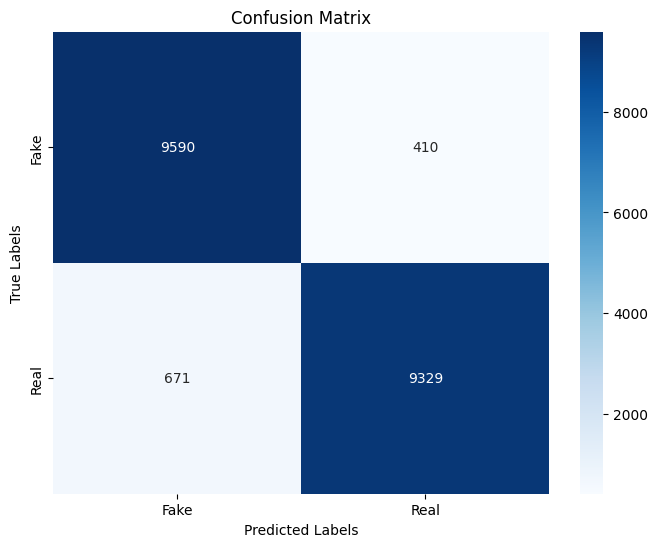

In [10]:
cm = confusion_matrix(all_labels, all_preds)
print('Confusion matrix:')
print(cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['Fake', 'Real'])
plt.yticks([0.5, 1.5], ['Fake', 'Real'], va='center')
plt.show()